# Low level libCZI python bindings API

## Instanciate a czi_reader

**czi_reader_object = czi_reader(filepath):**
Opens the .czi at the given path and returns a corresponding czi reader object.

In [1]:
from _pylibCZIrw import czi_reader

In [2]:
Czi_im = czi_reader("test/well.czi")

## Metadata handling

### Raw XML metadata
**GetXmlMetdata():** Returns the raw xml metadata of the czi (as a string)

In [3]:
Czi_im.GetXmlMetadata()

'<?xml version="1.0"?>\n<ImageDocument>\n <Metadata>\n  <Experiment Version="1.1">\n   <RunMode>OptimizeBeforePerformEnabled,ValidateAndAdaptBeforePerformEnabled</RunMode>\n   <BeforeHardwareSetting>Before Exp [AF488, AF555] Smart</BeforeHardwareSetting>\n   <AfterHardwareSetting>After Exp [AF488, AF555] Smart</AfterHardwareSetting>\n   <ExperimentBlockIndex>0</ExperimentBlockIndex>\n   <IsSegmented>false</IsSegmented>\n   <IsStandardMode>true</IsStandardMode>\n   <ImageTransferMode>MemoryMappedAndFileStream</ImageTransferMode>\n   <AutoSave IsActivated="false" EnableSingleFileSave="false">\n    <StorageFolder>C:\\Users\\m1srh\\Documents\\Zen_Output</StorageFolder>\n    <Name>New</Name>\n    <IsAutoSubFolder>true</IsAutoSubFolder>\n    <IsAutoSubFolderExternal>true</IsAutoSubFolderExternal>\n    <IsClosedOnCompletion>false</IsClosedOnCompletion>\n    <SingleFileSaveFormat>JPG</SingleFileSaveFormat>\n    <ConvertTo8Bit>false</ConvertTo8Bit>\n    <AddXmlMetadata>false</AddXmlMetadata>\n 

### Pixel Type
**GetChannelPixelType()**: Returns the pixelType of the given channel index

In [4]:
Czi_im.GetChannelPixelType(0)

<PixelType.Gray8: 0>

### Dimension size
**DimensionIndex:** Enum object representing a czi index, values can be: H, B, I, R, V, C, T, Z S   

In [5]:
from _pylibCZIrw import DimensionIndex

In [6]:
dim = DimensionIndex.S # Here the variable dim will represent the S (scene) Dimension

**GetDimensionSize(DimensionIndex):** Returns the size of the specified dimension

In [7]:
Czi_im.GetDimensionSize(dim) #the .czi has 300 scenes

300

### Subblock statistics
**GetSubBlockStats():** Returns a SubBlockStatistics object that can be use to retrieve a lot of usefull informations about the czi

In [8]:
stats = Czi_im.GetSubBlockStats()

**For instance stats can be use to get the bounding box of a specific scene**

In [9]:
scene0_x = stats.sceneBoundingBoxes[0].boundingBox.x # x position of top left corner of scene 0

In [10]:
scene0_y = stats.sceneBoundingBoxes[0].boundingBox.y # y position of top left corner of scene 0

In [11]:
scene0_w = stats.sceneBoundingBoxes[0].boundingBox.w # total width of scene 0

In [12]:
scene0_h = stats.sceneBoundingBoxes[0].boundingBox.h # total height of scene 0

## Reading Data: Arguments
For reading from a czi we need to specify the following arguments:
* ROI: region of interest of the plance we want to read
* BackgroundColor: color that we want to use to fill the image where there is no data
* Zoom: zoom factor you want to apply to the specified ROI
* Plane Coordinates: List of relevant coordinates for getting the 2D plane
* Scene filter: Scene to consider when extracting the plane

### ROI
To pass the roi to the read function we need to create a **Intrect** object

In [13]:
from _pylibCZIrw import IntRect

In [14]:
roi = IntRect()
roi.x = scene0_x
roi.y = scene0_y
roi.w = scene0_w
roi.h = scene0_h

### Background color
For the background color we need to create a **RbgFloatColor** object.
If the destination bitmap is a grayscale-type, then the mean from R, G and B is calculated and multiplied with the maximum pixel value (of the specific pixeltype). If it is a RGB-color type, then R, G and B are separately multiplied with the maximum pixel value. If any of R, G or B is NaN, then the background is not cleared.

In [15]:
from _pylibCZIrw import RgbFloatColor

In [16]:
bgColor = RgbFloatColor()
bgColor.r = 0
bgColor.g = 0
bgColor.b = 0 # Here the background color will be black (very uncommon choice)

### Zoom
Zoom value is a float  greater than 0, 1.0 for no zoom

In [17]:
zoom = 1.0

### Plane coordinates
A string, which is combination of dimensions and respective indexes seperated by a space, for examples **"C0 T0 Z0"** (only valid if C T and Z dimensions exists in the .czi)

In [18]:
coords = "C0"

### Scene filter
A string which is a list of indexes seperated by a space. Specifies which scenes needs to be considered when extrating the 2D plane

In [19]:
scene = "0"

### Pixel Type
Pixel type of the destination bitmap.

In [20]:
from _pylibCZIrw import PixelType
pixel_type = PixelType.Gray8

## Reading Data: Function Call
Once all the arguments below are specified accordingly to your .czi, you can use the **GetSingleChannelScalingTileAccessorData(IntRect roi, RgbFloatColor bgcolor, float zoom, str plane_dims, str scene_filter)**, which return a bitmap object

In [21]:
plane_bitmap = Czi_im.GetSingleChannelScalingTileAccessorData(pixel_type, roi, bgColor, zoom, coords, scene)

The bitmap can then be converted to a numpy array, don't forget **copy=False** 

In [22]:
import numpy as np

In [23]:
plane_image = np.array(plane_bitmap, copy=False)

In [24]:
from matplotlib import pyplot as plt

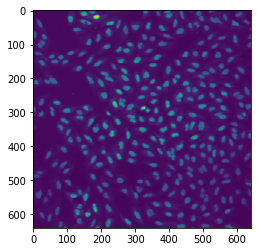

In [25]:
plt.imshow(plane_image)



## Writing Data: Instanciate a Writer

**czi_writer_object = czi_writer(filepath):**
Creates a .czi at the given path and returns a corresponding czi writer object.

In [26]:
from _pylibCZIrw import czi_writer

In [27]:
CziWriter = czi_writer("demo_names.czi")

## Convert the plane you want to write to a C++ Bitmap

**bitmap_object = PImage(np_array, PixelType):**
Converts the given np_array to a PImage bitmap object, this is needed to be able to call the Addplane function



In [28]:
demo_array = np.ones((180, 160), dtype='uint8')

In [29]:
from _pylibCZIrw import PImage, PixelType

demo_bitmap = PImage(demo_array, PixelType.Gray8)

## Write the plane in the czi document


In [30]:
CziWriter.AddTile("T0Z0C0",demo_bitmap, 0, 0, 0)

True

## Write the Metadatas


In [31]:
CziWriter.WriteMetadata("Document title", {0:"cusstom_name"})

## Close the writer object


In [32]:
CziWriter.close()